In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import pandas as pd
from collections import Counter


In [159]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [160]:
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备器设备：{device}")


使用设备器设备：mps


In [161]:
def read_text_file(file_path):
    try:
        with open(file_path,'r',encoding='utf-8') as file:
            text=file.read()
        print(f"successfully read {file_path}")
        return text
    except FileNotFoundError:
       print(f"file {file_path} not found")

file_path='/Users/wang/code/nlp/rnn_exercise/the_little_prince.txt'
text=read_text_file(file_path)

successfully read /Users/wang/code/nlp/rnn_exercise/the_little_prince.txt


In [162]:
def preprocess_text(text):
    text=text.lower()

    text=re.sub(r"[^a-zA-Z0-9]\s\.\?\!\:\,"," ",text)

    text=re.sub(r'\s+',' ',text)

    return text.strip()
processed_text=preprocess_text(text)
print(f"processed_text length is : {len(processed_text)}")
print(processed_text)

processed_text length is : 90322
i once when i was six years old i saw a magnificent picture in a book, called true stories from nature, about the primeval forest. it was a picture of a boa constrictor in the act of swallowing an animal. here is a copy of the drawing. boa in the book it said: "boa constrictors swallow their prey whole, without chewing it. after that they are not able to move, and they sleep through the six months that they need for digestion." i pondered deeply, then, over the adventures of the jungle. and after some work with a colored pencil i succeeded in making my first drawing. my drawing number one. it looked something like this: sombrero i showed my masterpiece to the grown-ups, and asked them whether the drawing frightened them. but they answered: "frighten? why should any one be frightened by a hat?" my drawing was not a picture of a hat. it was a picture of a boa constrictor digesting an elephant. but since the grown-ups were not able to understand it, i made

In [163]:
class Vocabulary:
    def __init__(self):
        self.char_to_idx={}
        self.idx_to_char={}
        self.voacab_size=0
    def build_vocab(self,text):
        chars=sorted(list(set(text)))
        self.voacab_size=len(chars)

        self.char_to_idx={char:idx for idx,char in enumerate(chars)}
        self.idx_to_char={idx:char for idx,char in enumerate(chars)}
        print(f"vocalbulary building finished,size:{self.voacab_size}")

    def text_to_indices(self,text):
        return [self.char_to_idx[char] for char in text if char in self.char_to_idx]
    def indices_to_text(self,indices):
        return ''.join([self.idx_to_char[idx] for idx in indices])
    
    def show_vocab(self):
        print(f"vocalbulary size:{self.voacab_size}")
        for char,idx in self.char_to_idx.items():
            print(f"{char}:{idx}")
    
vocabulary=Vocabulary()
vocabulary.build_vocab(processed_text)
vocabulary.show_vocab()

vocalbulary building finished,size:52
vocalbulary size:52
 :0
!:1
":2
$:3
':4
(:5
):6
,:7
-:8
.:9
0:10
1:11
2:12
3:13
4:14
5:15
6:16
7:17
8:18
9:19
::20
;:21
?:22
a:23
b:24
c:25
d:26
e:27
f:28
g:29
h:30
i:31
j:32
k:33
l:34
m:35
n:36
o:37
p:38
q:39
r:40
s:41
t:42
u:43
v:44
w:45
x:46
y:47
z:48
ï:49
—:50
…:51


In [164]:
def create_sequences(text_indices,seq_length):
    x=[]
    y=[]
    for i in range(len(text_indices)-seq_length):
        x.append(text_indices[i:i+seq_length])
        y.append(text_indices[i+seq_length])

    return torch.tensor(x,dtype=torch.long),torch.tensor(y,dtype=torch.long)

text_indices=vocabulary.text_to_indices(processed_text)
print(f"text can be converted to indices:{text_indices}")

seq_length=40
print(f"text can be converted to sequences with length {seq_length}:")

x,y=create_sequences(text_indices=text_indices,seq_length=seq_length)
print(f"created {len(x)} training sequences")
print(f"x:{x.shape}")
print(f"y:{y.shape}")
print(f"Input:{vocabulary.indices_to_text(x[0].tolist())}")
print(f"Output:{vocabulary.indices_to_text([y[0].tolist()])}")

text can be converted to indices:[31, 0, 37, 36, 25, 27, 0, 45, 30, 27, 36, 0, 31, 0, 45, 23, 41, 0, 41, 31, 46, 0, 47, 27, 23, 40, 41, 0, 37, 34, 26, 0, 31, 0, 41, 23, 45, 0, 23, 0, 35, 23, 29, 36, 31, 28, 31, 25, 27, 36, 42, 0, 38, 31, 25, 42, 43, 40, 27, 0, 31, 36, 0, 23, 0, 24, 37, 37, 33, 7, 0, 25, 23, 34, 34, 27, 26, 0, 42, 40, 43, 27, 0, 41, 42, 37, 40, 31, 27, 41, 0, 28, 40, 37, 35, 0, 36, 23, 42, 43, 40, 27, 7, 0, 23, 24, 37, 43, 42, 0, 42, 30, 27, 0, 38, 40, 31, 35, 27, 44, 23, 34, 0, 28, 37, 40, 27, 41, 42, 9, 0, 31, 42, 0, 45, 23, 41, 0, 23, 0, 38, 31, 25, 42, 43, 40, 27, 0, 37, 28, 0, 23, 0, 24, 37, 23, 0, 25, 37, 36, 41, 42, 40, 31, 25, 42, 37, 40, 0, 31, 36, 0, 42, 30, 27, 0, 23, 25, 42, 0, 37, 28, 0, 41, 45, 23, 34, 34, 37, 45, 31, 36, 29, 0, 23, 36, 0, 23, 36, 31, 35, 23, 34, 9, 0, 30, 27, 40, 27, 0, 31, 41, 0, 23, 0, 25, 37, 38, 47, 0, 37, 28, 0, 42, 30, 27, 0, 26, 40, 23, 45, 31, 36, 29, 9, 0, 24, 37, 23, 0, 31, 36, 0, 42, 30, 27, 0, 24, 37, 37, 33, 0, 31, 42, 0, 41,

In [165]:
class RNNModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_layers=1,dropout=0.25):
        super(RNNModel,self).__init__()
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers

        self.embedding=nn.Embedding(vocab_size,embedding_dim)
        self.rnn=nn.RNN(embedding_dim,hidden_dim,num_layers,batch_first=True,dropout=dropout if num_layers>1 else 0)
        
        self.fc=nn.Linear(hidden_dim,vocab_size)
        self.dropout=nn.Dropout(dropout)

    def forward(self,x,hidden):
        embedded=self.embedding(x)
        embedded=self.dropout(embedded)

        output,hidden=self.rnn(embedded,hidden)
        output=self.dropout(output)
        output=self.fc(output)
        return output,hidden
    
    def init_hidden(self,batch_size):
        return torch.zeros(self.num_layers,batch_size,self.hidden_dim).to(device)
    
embedding_dim=128
hidden_dim=256
num_layers=2

model=RNNModel(vocabulary.voacab_size,embedding_dim,hidden_dim,num_layers)

print("model structure")
print(model)

model structure
RNNModel(
  (embedding): Embedding(52, 128)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=256, out_features=52, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [166]:
from torch.utils.data import DataLoader,TensorDataset

dataset=TensorDataset(x,y)

batch_size=64
train_dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
print(f"Dataloader:{len(train_dataloader)} batches of {batch_size} samples")

for batch_idx,(data,targets) in enumerate(train_dataloader):
    print(f"batch {batch_idx}--data shape:{data.shape}--targets shape:{targets.shape}")
    break



Dataloader:1411 batches of 64 samples
batch 0--data shape:torch.Size([64, 40])--targets shape:torch.Size([64])


In [167]:
def train_model(model,dataloader,epochs,learning_rate):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    model=model.to(device)
    losses=[]
    model.train()
    for epoch in range(epochs):
        total_loss=0
        batch_count=0
        for batch_idx,(data,targets) in enumerate(dataloader):
            data=data.to(device)
            targets=targets.to(device)

            hidden=model.init_hidden(data.size(0))

            outputs,hidden=model(data,hidden)
            outputs=outputs[:,-1,:]
            targets=targets.reshape(-1)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

            if batch_idx%10==0:
                print(f"Epoch: {epoch+1}/{epochs}, Step: {batch_idx}/{len(dataloader)}, Loss: {total_loss/batch_count:.4f}")
        avg_loss=total_loss/batch_count
        losses.append(avg_loss)
        print(f"Epoch: {epoch+1}/{epochs}, Avg. Loss: {avg_loss:.4f}")
            
    return losses

In [169]:
#start to train the model
print("start to train the model")
epochs=10 
learning_rate=0.001
losses=train_model(model=model,dataloader=train_dataloader,epochs=epochs,learning_rate=learning_rate)
print("Training finished")

start to train the model
Epoch: 1/10, Step: 0/1411, Loss: 3.9818
Epoch: 1/10, Step: 10/1411, Loss: 3.4389
Epoch: 1/10, Step: 20/1411, Loss: 3.1993
Epoch: 1/10, Step: 30/1411, Loss: 3.0485
Epoch: 1/10, Step: 40/1411, Loss: 2.9486
Epoch: 1/10, Step: 50/1411, Loss: 2.8786
Epoch: 1/10, Step: 60/1411, Loss: 2.8040
Epoch: 1/10, Step: 70/1411, Loss: 2.7638
Epoch: 1/10, Step: 80/1411, Loss: 2.7294
Epoch: 1/10, Step: 90/1411, Loss: 2.7016
Epoch: 1/10, Step: 100/1411, Loss: 2.6614
Epoch: 1/10, Step: 110/1411, Loss: 2.6448
Epoch: 1/10, Step: 120/1411, Loss: 2.6217
Epoch: 1/10, Step: 130/1411, Loss: 2.6010
Epoch: 1/10, Step: 140/1411, Loss: 2.5880
Epoch: 1/10, Step: 150/1411, Loss: 2.5700
Epoch: 1/10, Step: 160/1411, Loss: 2.5556
Epoch: 1/10, Step: 170/1411, Loss: 2.5402
Epoch: 1/10, Step: 180/1411, Loss: 2.5236
Epoch: 1/10, Step: 190/1411, Loss: 2.5133
Epoch: 1/10, Step: 200/1411, Loss: 2.5009
Epoch: 1/10, Step: 210/1411, Loss: 2.4840
Epoch: 1/10, Step: 220/1411, Loss: 2.4736
Epoch: 1/10, Step: 2

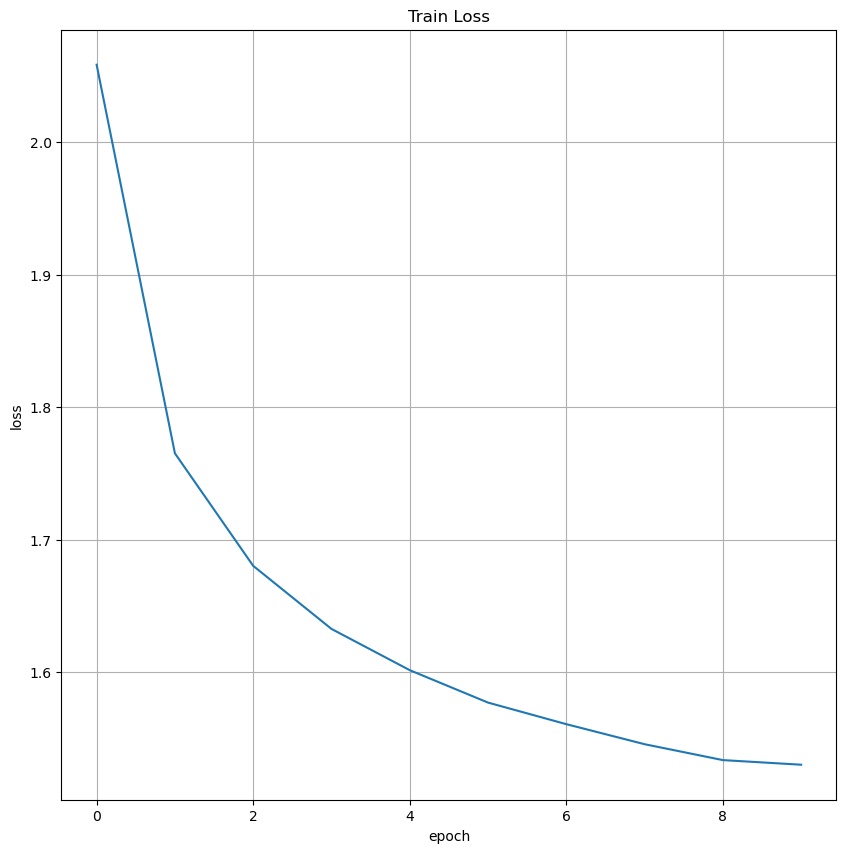

In [170]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

In [175]:
def generate_text(model, seed_text, vocabulary, length=100, temperature=1.0):

    model.eval()
    
    # 将起始文本转换为索引
    chars = [vocabulary.char_to_idx.get(ch, 0) for ch in seed_text]
    
    with torch.no_grad():
        input_seq = torch.tensor([chars]).to(device)
        
        # 初始化隐藏状态
        hidden = model.init_hidden(1)
        generated_chars = chars.copy()
        
        # 逐个生成字符
        for _ in range(length):
            # 获取模型输出
            output, hidden = model(input_seq, hidden)
            
            # 取最后一个时间步的输出
            output = output[:, -1, :]
            
            # 应用温度参数
            output = output / max(temperature, 1e-10)
            
            # 检查输出有效性
            if torch.isnan(output).any() or torch.isinf(output).any():
                print("警告: 模型输出包含无效值")
                output = torch.zeros_like(output)
            
            # 应用softmax获取概率分布
            probs = torch.softmax(output, dim=-1)
            
            # 确保概率分布有效
            if torch.isnan(probs).any() or torch.isinf(probs).any():
                probs = torch.ones_like(probs) / probs.shape[-1]
            
            # 采样下一个字符
            try:
                next_char_idx = torch.multinomial(probs, 1).item()
            except:
                next_char_idx = torch.argmax(probs).item()
            
            # 添加到生成序列
            generated_chars.append(next_char_idx)
            
            # 更新输入序列
            input_seq = torch.tensor([[next_char_idx]]).to(device)
        
        # 转换回文本
        generated_text = ''.join([vocabulary.idx_to_char.get(idx, ' ') for idx in generated_chars])
    
    return generated_text

# 测试生成文本
try:
    generated_text = generate_text(
        model=model,
        seed_text="The little prince",
        vocabulary=vocabulary,
        length=50,
        temperature=0.8
    )
    print("生成的文本:")
    print(generated_text)
except Exception as e:
    print(f"生成文本时出错: {e}")

生成的文本:
 he little prince down mither," said the grown-ups, them. i said to
